In [3]:
# Import libraries and dependencies
import os
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation

In [4]:
# Load the environment variables by calling the load_dotenv function
load_dotenv()

True

In [5]:
# Set Alpaca API key and secret by calling the os.getenv function and referencing the environment variable names
# Set each environment variable to a notebook variable of the same name
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Check the values were imported correctly by evaluating the type of each
display(type(alpaca_api_key))
display(type(alpaca_secret_key))

str

str

In [6]:
# Create your Alpaca API REST object by calling Alpaca's tradeapi.REST function
# Set the parameters to your alpaca_api_key, alpaca_secret_key and api_version="v2" 
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

In [7]:
# Block of code for CLI / Questionary

In [8]:
# porfolio_1_tickers = 

In [9]:
# portfolio_2_tickers = 

In [10]:
# tickers must be sorted alphabetically

In [11]:
# Create the list for the required tickers
tickers = ["AGG", "SPY", "VTV"]

In [12]:
# Set the values for start_date and end_date using the pd.Timestamp function
# Inside the function set the date parameter to the prior business day 
# The start and end data should be 2017-05-01 to 2020-05-01
# Set the parameter tz to "America/New_York", 
# Set this all to the ISO format by calling the isoformat function 
start_date = pd.Timestamp("2018-12-31", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2021-12-31", tz="America/New_York").isoformat()

In [13]:
# Set timeframe to one day (1D)
timeframe = "1D"

# Set number of rows to 1000 to retrieve the maximum amount of rows
limit_rows = 1000

In [14]:
# Use the Alpaca get_barset function to gather the price information for each ticker
# Include the function parameters: tickers, timeframe, start, end, and limit
# Be sure to call the df property to ensure that the returned information is set as a DataFrame
prices_df = alpaca.get_barset(
    tickers,
    timeframe,
    start=start_date,
    end=end_date,
    limit=limit_rows
).df

# Review the first five rows of the resulting DataFrame 
prices_df.head()

AGG                                          \
                             open     high       low    close      volume   
time                                                                        
2018-12-31 00:00:00-05:00  106.12  106.510  105.6200  106.495   8349838.0   
2019-01-02 00:00:00-05:00  106.55  106.610  106.4701  106.585  10164756.0   
2019-01-03 00:00:00-05:00  106.57  107.075  106.5700  107.020   6260265.0   
2019-01-04 00:00:00-05:00  106.66  106.720  106.5500  106.695   7755476.0   
2019-01-07 00:00:00-05:00  106.72  106.790  106.4600  106.470   6545877.0   

                              SPY                                       VTV  \
                             open    high     low   close     volume   open   
time                                                                          
2018-12-31 00:00:00-05:00  249.56  250.16  247.47  248.55  100767777  97.55   
2019-01-02 00:00:00-05:00  245.98  251.21  245.95  249.89  107236613  96.49   
2019-01-03 00:00:00-05:00  248.23  248.57  244.03  244.46  113782919  97.55   
2019-01-04 00:00:00-05:00  247.59  253.11  247.17  252.41  122528832  97.45   
2019-01-07 00:00:00-05:00  252.69  255.95  251.69  254.40   88317608  99.06   

                                                              
                             high      low  close     volume  
time                                                          
2018-12-31 00:00:00-05:00   97.85  96.8633  97.33  5348723.0  
2019-01-02 00:00:00-05:00   98.26  96.3836  97.87  4285216.0  
2019-01-03 00:00:00-05:00   97.73  96.0800  96.34  2642086.0  
2019-01-04 00:00:00-05:00   99.23  97.2500  98.99  2361751.0  
2019-01-07 00:00:00-05:00  100.24  98.5500  99.58  2834056.0

In [16]:
# Configure a Monte Carlo simulation to forecast five years cumulative returns
# Use an even weight of .33 across all 3 stocks
MC_even_weight = MCSimulation(
    portfolio_data = prices_df,
    weights = [.33,.33,.33],
    num_simulation = 100,
    num_trading_days = 252*5
)

# Printing the first five rows of the simulation input data
MC_even_weight.portfolio_data.head()

AGG                                          \
                             open     high       low    close      volume   
time                                                                        
2018-12-31 00:00:00-05:00  106.12  106.510  105.6200  106.495   8349838.0   
2019-01-02 00:00:00-05:00  106.55  106.610  106.4701  106.585  10164756.0   
2019-01-03 00:00:00-05:00  106.57  107.075  106.5700  107.020   6260265.0   
2019-01-04 00:00:00-05:00  106.66  106.720  106.5500  106.695   7755476.0   
2019-01-07 00:00:00-05:00  106.72  106.790  106.4600  106.470   6545877.0   

                                           SPY                          \
                          daily_return    open    high     low   close   
time                                                                     
2018-12-31 00:00:00-05:00          NaN  249.56  250.16  247.47  248.55   
2019-01-02 00:00:00-05:00     0.000845  245.98  251.21  245.95  249.89   
2019-01-03 00:00:00-05:00     0.004081  248.23  248.57  244.03  244.46   
2019-01-04 00:00:00-05:00    -0.003037  247.59  253.11  247.17  252.41   
2019-01-07 00:00:00-05:00    -0.002109  252.69  255.95  251.69  254.40   

                                                     VTV                   \
                              volume daily_return   open    high      low   
time                                                                        
2018-12-31 00:00:00-05:00  100767777          NaN  97.55   97.85  96.8633   
2019-01-02 00:00:00-05:00  107236613     0.005391  96.49   98.26  96.3836   
2019-01-03 00:00:00-05:00  113782919    -0.021730  97.55   97.73  96.0800   
2019-01-04 00:00:00-05:00  122528832     0.032521  97.45   99.23  97.2500   
2019-01-07 00:00:00-05:00   88317608     0.007884  99.06  100.24  98.5500   

                                                          
                           close     volume daily_return  
time                                                      
2018-12-31 00:00:00-05:00  97.33  5348723.0          NaN  
2019-01-02 00:00:00-05:00  97.87  4285216.0     0.005548  
2019-01-03 00:00:00-05:00  96.34  2642086.0    -0.015633  
2019-01-04 00:00:00-05:00  98.99  2361751.0     0.027507  
2019-01-07 00:00:00-05:00  99.58  2834056.0     0.005960

In [17]:
# Run a Monte Carlo simulation to forecast five years cumulative returns
MC_even_weight.calc_cumulative_return()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.002772,1.000522,1.008280,0.994193,0.996688,1.006893,1.004694,0.996610,1.001695,0.999078,...,1.000180,1.002785,1.003091,0.993696,0.990352,1.003002,1.000028,0.996604,0.994677,1.006494
2,1.005249,1.006450,1.008072,0.993539,0.995515,0.998134,1.017050,1.009130,1.010385,0.999843,...,0.998803,1.005061,1.011664,0.986636,0.987386,0.997020,1.003525,1.005045,0.999263,1.007986
3,0.996865,1.011627,1.018617,0.985412,0.993260,0.994117,1.015939,1.021561,1.007415,1.010002,...,1.000625,1.012414,1.001589,0.982024,0.987686,0.995912,0.999934,1.003428,1.005718,1.013631
4,1.004333,1.013565,1.021286,0.986235,0.991981,0.986405,1.026559,1.028936,1.017847,1.003747,...,0.993873,1.015609,1.004474,0.989369,0.996822,1.009514,0.991120,0.994323,1.006682,1.012068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,1.746353,2.063061,2.235031,2.394772,1.201421,3.144228,2.443574,1.969085,3.385479,2.124526,...,1.654061,2.023958,2.347355,1.134187,2.041259,1.232450,2.487756,1.498691,1.297522,1.744358
1257,1.758872,2.038920,2.261479,2.394736,1.211893,3.174136,2.456347,1.969308,3.393800,2.140529,...,1.639054,2.021048,2.359654,1.149286,2.024343,1.224706,2.512150,1.502949,1.296612,1.739530
1258,1.755104,2.026860,2.232686,2.393211,1.191908,3.148998,2.444493,1.966579,3.392035,2.139424,...,1.661725,2.028163,2.350491,1.151811,2.022939,1.234704,2.507335,1.485950,1.303478,1.745124
1259,1.746901,2.021670,2.204449,2.405355,1.181554,3.206177,2.423701,1.966861,3.394115,2.151597,...,1.649095,2.005551,2.305941,1.143599,2.014747,1.218808,2.545112,1.480428,1.299634,1.719610


In [27]:
# Create a new variable for the simulation above
sim_df = MC_even_weight.calc_cumulative_return()

In [28]:
# Computes and returns a dataframe for daily price returns of each simulation for each trading day
shift_df = sim_df.shift(-1)
returns_df = (shift_df - sim_df) / sim_df
returns_df

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.002379,0.003065,-0.003766,0.006267,-0.001926,-0.002970,-0.003529,0.006134,-0.001419,-0.011597,...,0.004947,-0.005154,0.004779,0.001283,-0.004456,0.007694,-0.001453,0.010542,-0.006140,0.008340
1,0.006386,-0.003634,0.004301,0.003439,0.013504,0.005049,-0.005153,-0.000290,-0.009971,-0.006650,...,-0.000758,-0.011951,0.001345,-0.000531,0.008644,0.001000,-0.010503,0.010831,0.004208,-0.010902
2,0.014187,0.004244,-0.001966,0.000443,0.009833,0.018699,0.001633,0.003636,0.001546,-0.001117,...,0.009602,0.003998,-0.008162,-0.005615,0.001486,-0.010511,-0.001641,-0.000488,-0.014844,0.002164
3,-0.009609,0.004870,0.000661,0.004501,0.006765,-0.004852,0.004345,-0.006161,-0.001452,-0.002793,...,-0.002340,-0.006708,0.002649,0.009459,-0.000663,0.003773,0.000027,0.012932,0.002147,0.008690
4,0.005555,0.007792,0.001424,-0.003952,0.004602,0.005275,0.002195,0.000264,-0.013782,0.004092,...,-0.006920,-0.000987,-0.013646,-0.009426,0.015361,-0.004272,-0.002509,0.007764,-0.001231,0.004554
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,-0.002725,0.008043,0.008412,-0.006010,0.008397,-0.000248,-0.015722,-0.000398,-0.002925,0.008895,...,-0.000721,0.001771,-0.001623,0.005310,0.001211,-0.001446,-0.002537,-0.000515,-0.006064,0.008142
1257,-0.007161,0.010057,0.005085,0.003065,0.008225,0.010809,-0.004468,0.003187,0.000828,0.002825,...,0.007937,-0.003890,-0.000300,0.002768,0.002533,-0.001547,0.002703,-0.004705,0.005937,0.007028
1258,0.001095,0.004979,-0.002252,-0.007312,0.009141,0.007065,0.012102,0.008037,0.008854,0.004412,...,-0.004645,0.006534,-0.004505,-0.000837,-0.011627,-0.009372,0.004839,-0.003431,0.004969,0.003168
1259,-0.004293,0.014348,-0.000011,0.003162,0.004169,-0.005893,-0.003655,-0.002229,0.005475,-0.010302,...,-0.000739,0.003075,-0.014626,0.001297,-0.006883,0.000057,-0.006594,0.012749,-0.003533,-0.006253


In [30]:
# Computes the standard deviation of returns for each simulation
annual_std_list = returns_df.std() * (252 **0.5)
annual_std_list

0     0.106056
1     0.107765
2     0.106591
3     0.103461
4     0.106030
        ...   
95    0.109658
96    0.109060
97    0.105876
98    0.107315
99    0.104433
Length: 100, dtype: float64

In [34]:
# and then averages the results to come up with an estimated standard deviation of the portfolio
annual_std = annual_std_list.mean()
annual_std

0.10616601000550667

In [35]:
# Repeats this process to come up with an annual return for each simulation
annual_ret_list = returns_df.mean() * 252
annual_ret_list

0     0.116617
1     0.128260
2     0.119721
3     0.120266
4     0.133194
        ...   
95    0.123124
96    0.171025
97    0.124510
98    0.193830
99    0.136505
Length: 100, dtype: float64

In [36]:
# and then averages the results to come up with an estimated return of the portfolio
annual_ret = annual_ret_list.mean()
annual_ret

0.14033522124346093

In [37]:
# Input for estimated income of the portfolio
annual_income = .02

In [38]:
import numpy as np
import random
#from scipy.stats import norm

In [46]:
#A function to simulate a random set of returns for a portfolio over a desired time horizon given various parameters
def simulate_return(mean_return, standard_dev, annual_income, simulated_quarters, number_of_simulations, initial_investment):
    
    #quarterly return of the portfolio plus quarterly income. the mean return could be a call to summary statistics and the annual income to a csv.
    quarterly_ret = (mean_return/4) + (annual_income/4)
    
    #quarterly standard deviation of the portfolio. standard deviation could be a call to summary statistics.
    quarterly_stdev = standard_dev / (4**0.5)
    
    #returns a random set of standard deviation multipliers plus the mean return. For example return +/- 1 SD or return +/- (1.65 x Std) to obtain a list of random returns
    quarterly_returns = 1 + np.random.normal(quarterly_ret, quarterly_stdev, (simulated_quarters,number_of_simulations))
    
    #defines the portfolio variable in the same array shape as the previously estimated returns
    portfolio = np.zeros_like(quarterly_returns)
    
    #sets an initial investment for the simulation
    portfolio[0] = initial_investment
    
    #for loop to project out portfolio market value for each simulation
    for t in range (1, simulated_quarters):
        portfolio[t] = (portfolio[t-1]*quarterly_returns[t])
    return pd.DataFrame(portfolio)

<AxesSubplot:>

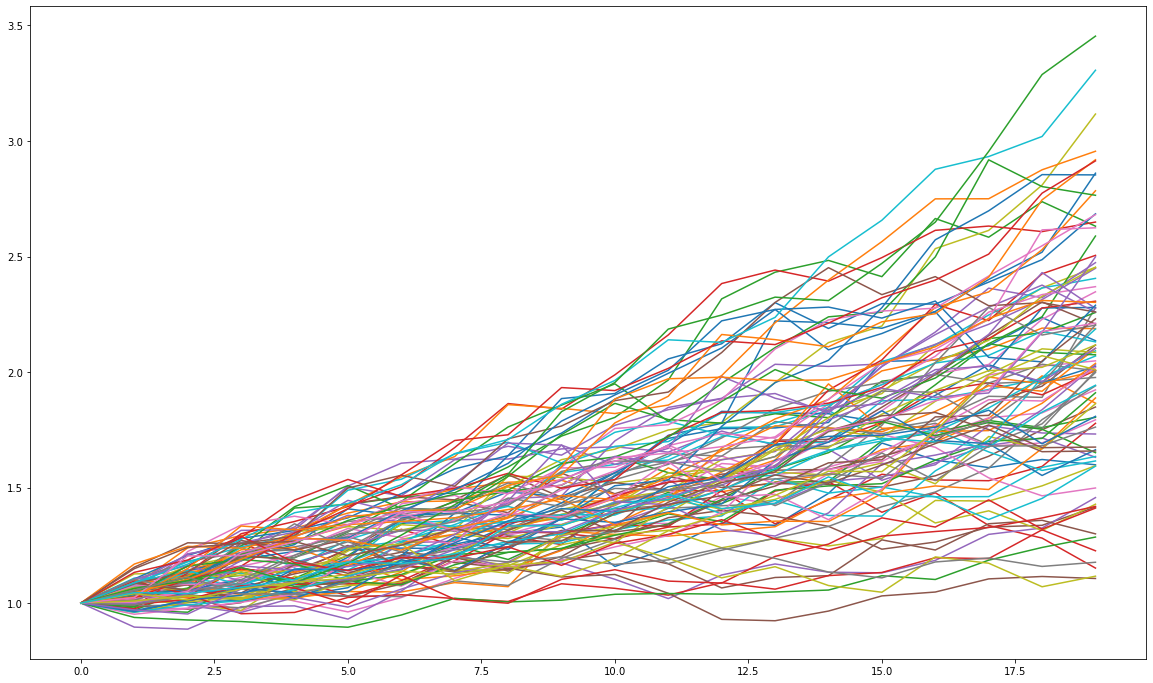

In [47]:
#plot the results. Ideally we could simply use this function to allow easily interchangable parameters 
simulate_return(annual_ret,annual_std,annual_income,20,100,1).plot(figsize = (20,12), legend=None)

In [49]:
simulate_return(annual_ret,annual_std,annual_income,20,100,1).tail(1).mean(axis=1)

19    2.126953
dtype: float64

In [50]:
# Insert code for interactive Dashboard